In [1]:
import warnings
from pathlib import Path

import matplotlib.patches as patches

#
import numpy as np
import pytorch_hyperlight as pth

#
###
import pytorch_lightning as pl
import pytorch_lightning.metrics as metrics
import torch
import torch.nn.functional as F

#
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from pytorch_lightning import Callback

###
from ray import tune

#
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets.mnist import MNIST
from transformers import AdamW, get_linear_schedule_with_warmup

/home/peter/.conda/envs/ml-devenv/lib/python3.8/site-packages/wandb/util.py:37: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence
/home/peter/.conda/envs/ml-devenv/lib/python3.8/site-packages/wandb/vendor/graphql-core-1.1/graphql/type/directives.py:55: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  assert isinstance(locations, collections.Iterable), 'Must provide locations for directive.'


In [2]:
USAGE_MODE = "single-run"  # choose from 'single-run' and 'hyper-opt'
# USAGE_MODE = "hyper-opt"  # choose from 'single-run' and 'hyper-opt'

/home/peter/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
FAST_DEV_RUN = True  # if true, simplifed configurations running for just a few epochs are used for making sure there are no obvious bugs

In [4]:
EXPERIMENT_ID = "boring-mnist"

DATASETS_PATH = Path("/home/peter/_Git/_ML/dlschool-solutions/term1/task5/data")

warnings.filterwarnings("ignore")


# a dedicated function for creating datasets
# please note how 'full_train_dataset' is created along with train,
# val and test datasets
def create_datasets(val_size=0.2):
    SEED = 16
    pl.seed_everything(SEED)
    #
    full_train_dataset = MNIST(
        DATASETS_PATH, train=True, download=True, transform=transforms.ToTensor()
    )
    test_dataset = MNIST(
        DATASETS_PATH, train=False, download=True, transform=transforms.ToTensor()
    )
    n_full_train_samples = len(full_train_dataset)
    n_val_samples = int(n_full_train_samples * val_size)
    train_dataset, val_dataset = random_split(
        full_train_dataset, [n_full_train_samples - n_val_samples, n_val_samples]
    )

    n_classes = len(MNIST.classes)

    return {
        "full_train_dataset": full_train_dataset,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
        "n_classes": n_classes,
    }

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
# a dedicated function for creating dataloaders
# 'full_train_loader' is created along with standard 3 loaderers
# for training, validation and testing datasets
def configure_dataloaders(batch_size, n_workers=4, val_size=0.2):
    #
    SHUFFLE = True
    SAMPLER = None
    #
    result_dict = create_datasets(val_size)
    #
    for prefix in ["train", "full_train"]:

        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=SHUFFLE,
            sampler=SAMPLER,
            num_workers=n_workers,
            pin_memory=True,
        )
    #
    for prefix in ["val", "test"]:
        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=False,
            num_workers=n_workers,
            pin_memory=True,
        )

    return result_dict

Let us make sure our dataloaders can be created correctly

In [7]:
BATCH_SIZE = 32

loaders_dict = configure_dataloaders(BATCH_SIZE)

loaders_dict

batch = next(iter(loaders_dict["train_loader"]))
assert len(batch[0]) > 0

In [8]:
result_dict = create_datasets(0.2)
len(result_dict["full_train_dataset"])

60000

In [9]:
loaders_dict["n_classes"]

10

### Defining the model

Let define a dedicated class for metrics calculation

In [10]:
class LitMetricsCalc(torch.nn.Module):
    def __init__(self, prefix, num_classes):
        super(LitMetricsCalc, self).__init__()
        self.acc = metrics.classification.Accuracy()
        self.f1 = metrics.classification.F1(num_classes=num_classes, average="macro")
        self.rec = metrics.classification.Recall(
            num_classes=num_classes, average="macro"
        )
        self.prec = metrics.classification.Precision(
            num_classes=num_classes, average="macro"
        )
        self.prefix = prefix

    def step(self, logit, target):
        probs = torch.softmax(logit, dim=1)
        prefix = self.prefix
        self.acc(probs, target)
        self.f1(probs, target)
        self.prec(probs, target)
        self.rec(probs, target)

        return {
            f"{prefix}_acc": self.acc,
            f"{prefix}_f1": self.f1,
            f"{prefix}_prec": self.prec,
            f"{prefix}_rec": self.rec,
        }

In [11]:
class Backbone(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.l0 = torch.nn.Linear(28 * 28, 256)
        self.l1 = torch.nn.Linear(256, 128)
        self.l2 = torch.nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.l0(x))
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        return x

In [12]:
class LitBackbone(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        #
        n_classes = self.hparams.n_classes
        #
        model = Backbone(n_classes)
        #
        self.model = model
        self.train_metric_calc = LitMetricsCalc("train", num_classes=n_classes)
        self.val_metric_calc = LitMetricsCalc("val", num_classes=n_classes)
        self.test_metric_calc = LitMetricsCalc("test", num_classes=n_classes)
        self.freeze()

    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_tail(self, ind_layer):
        assert ind_layer >= 0
        ind = ind_layer
        while True:
            if ind == 0:
                for param in self.model.l2.parameters():
                    param.requires_grad = True
            elif ind == 1:
                for param in self.model.l1.parameters():
                    param.requires_grad = True
            elif ind == 2:
                for param in self.model.l0.parameters():
                    param.requires_grad = True
            ind -= 1
            if ind < 0:
                break

    def configure_optimizers(self):
        optimizer = AdamW(
            self.model.parameters(),
            lr=self.hparams.lr,
            betas=(0.9, 0.999),
            eps=1e-8,
        )

        scheduler = get_linear_schedule_with_warmup(
            optimizer, self.hparams.warmup, self.hparams.n_train_steps
        )
        return [optimizer], [
            {"scheduler": scheduler, "interval": "step", "frequency": 1}
        ]

    def forward(self, inputs):
        logits = self.model(inputs)
        return logits

    def forward_batch(self, batch):
        inputs = batch[0]
        return self(inputs)

    def __calc_loss(self, logits, target, log_label):
        loss = F.cross_entropy(logits, target)
        self.log(f"{log_label}_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def __stage_step(self, metric_calc, batch, batch_idx, stage):
        logits = self.forward_batch(batch)
        mval_dict = metric_calc.step(logits, batch[1])
        self.log_dict(mval_dict, prog_bar=True, on_step=True, on_epoch=True)
        loss = self.__calc_loss(logits, batch[1], stage)
        return loss

    def training_step(self, batch, batch_idx):
        return self.__stage_step(self.train_metric_calc, batch, batch_idx, "train")

    def test_step(self, batch, batch_idx):
        return self.__stage_step(self.test_metric_calc, batch, batch_idx, "test")

    def validation_step(self, batch, batch_idx):
        return self.__stage_step(self.val_metric_calc, batch, batch_idx, "val")

In [13]:
N_CLASSES = loaders_dict["n_classes"]
LMODULE_CLASS = LitBackbone

In [14]:
CONFIG = {
    "lr": 6.2e-5,  # Initial learning rate
    "warmup": 200,  # for StepLR LR scheduler
    "gradient_clip_val": 0,
    # "max_epochs": 30,  # the actual number can be less due to early stopping
    "max_epochs": 10,  # the actual number can be less due to early stopping
    "batch_size": 64,  # the maximum for this model and RTX 2070,
    "n_classes": N_CLASSES,
    "unfreeze_epochs": [0, 1],  #
}

TUNE_CONFIG = {
    "seed": 16,
    "metric_to_optimize": "val_f1_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_f1_epoch",
        "val_acc_epoch",
    ],  # Ray
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    "gpu_per_trial": 0,  # Ray
    "n_checkpoints_to_keep": 1,  # Ray
    "grace_period": 6,  # Ray
    "epoch_upper_limit": 45,  # Ray
    "n_samples": 40,  # Ray
    # "n_samples": 3,
    "ptl_trainer_patience": 7,  # PTL Trainer
    # "ptl_precision": 16,  # PTL Trainer
    "ptl_precision": 32,  # PTL Trainer
    #
    "train_loader_name": "train_loader",
    "val_loader_name": "val_loader",
    "test_loader_name": "test_loader",
    #
    "batch_size_main": 32,  # batch size for validation runs in the main process once all Ray Tune trials are finished
    "gpus": 0,
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    TUNE_CONFIG["n_samples"] = 2
    TUNE_CONFIG["gpu_per_trial"] = 0

In [16]:
class UnfreezeModelTailCallback(Callback):
    def __init__(self, epoch_vec):
        super().__init__()
        self.epoch_vec = epoch_vec

    def on_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch <= self.epoch_vec[0]:
            pl_module.unfreeze_tail(0)
        elif trainer.current_epoch <= self.epoch_vec[1]:
            pl_module.unfreeze_tail(1)
        else:
            pl_module.unfreeze()


pl_callbacks = [UnfreezeModelTailCallback(CONFIG["unfreeze_epochs"])]

In [17]:
ptl_ray_runner = pth.Runner(
    configure_dataloaders,
    pl_callbacks=pl_callbacks,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | Backbone       | 235 K 
1 | train_metric_calc | LitMetricsCalc | 0     
2 | val_metric_calc   | LitMetricsCalc | 0     
3 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
0         Trainable params
235 K     Non-trainable params
235 K     Total params


|   Train/Val |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_rec |   train_rec |   val_prec |   train_prec |   val_loss |   train_loss |
|------------:|---------:|-----------:|----------:|------------:|----------:|------------:|-----------:|-------------:|-----------:|-------------:|
|           0 |   0.0318 |     0.0334 |    0.0969 |      0.1109 |    0.1118 |      0.1017 |     0.0188 |       0.0201 |     2.3055 |       2.3045 |


|   Train/Val |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_rec |   train_rec |   val_prec |   train_prec |   val_loss |   train_loss |
|------------:|---------:|-----------:|----------:|------------:|----------:|------------:|-----------:|-------------:|-----------:|-------------:|
|           1 |   0.0321 |     0.0283 |    0.0969 |      0.0922 |    0.1118 |       0.094 |      0.019 |        0.017 |     2.3053 |       2.3085 |


|   Train/Val |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_rec |   train_rec |   val_prec |   train_prec |   val_loss |   train_loss |
|------------:|---------:|-----------:|----------:|------------:|----------:|------------:|-----------:|-------------:|-----------:|-------------:|
|           2 |   0.0345 |     0.0327 |    0.1031 |         0.1 |    0.1197 |      0.1113 |     0.0205 |       0.0204 |     2.3042 |       2.3084 |


|   Reval |   val_f1 |   reval_f1 |   train_f1 |   val_acc |   reval_acc |   train_acc |   val_rec |   reval_rec |   train_rec |   val_prec |   reval_prec |   train_prec |   val_loss |   reval_loss |   train_loss |
|--------:|---------:|-----------:|-----------:|----------:|------------:|------------:|----------:|------------:|------------:|-----------:|-------------:|-------------:|-----------:|-------------:|-------------:|
|       2 |   0.0345 |     0.0345 |     0.0327 |    0.1031 |      0.1031 |         0.1 |    0.1197 |      0.1197 |      0.1113 |     0.0205 |       0.0205 |       0.0204 |     2.3042 |       2.3042 |       2.3084 |


|   Test |   val_f1 |   train_f1 |   test_f1 |   val_acc |   train_acc |   test_acc |   val_rec |   train_rec |   test_rec |   val_prec |   train_prec |   test_prec |   val_loss |   train_loss |   test_loss |
|-------:|---------:|-----------:|----------:|----------:|------------:|-----------:|----------:|------------:|-----------:|-----------:|-------------:|------------:|-----------:|-------------:|------------:|
|      2 |   0.0345 |     0.0327 |    0.0302 |    0.1031 |         0.1 |     0.1094 |    0.1197 |      0.1113 |     0.1015 |     0.0205 |       0.0204 |      0.0184 |     2.3042 |       2.3084 |       2.303 |


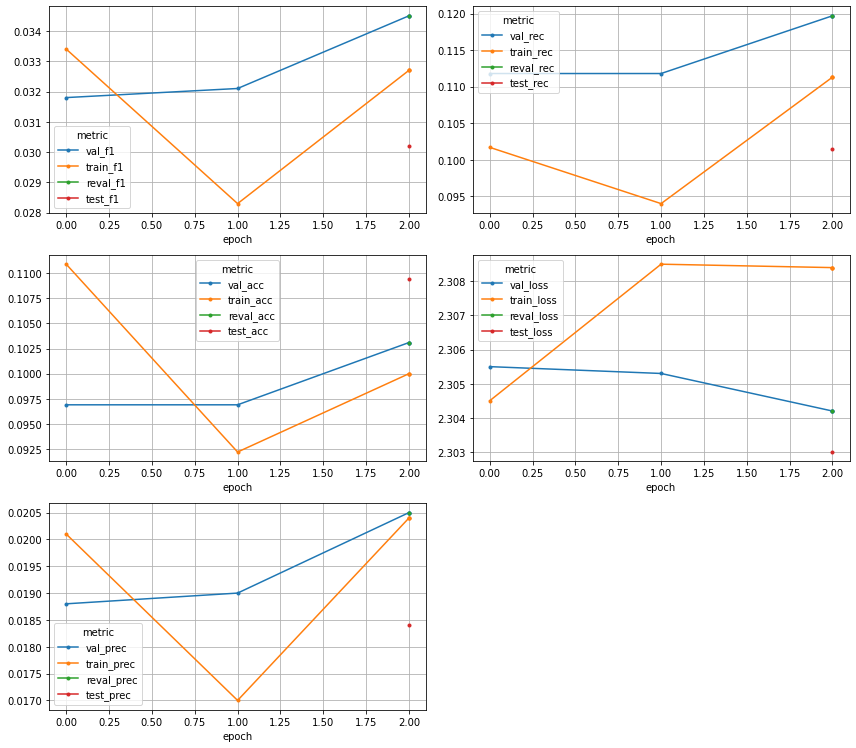

In [18]:
if USAGE_MODE == "single-run":
    best_result = ptl_ray_runner.run_single_trial(LMODULE_CLASS, CONFIG, TUNE_CONFIG)
    #
    best_result["metrics"].plot()

### Running a hyper-parameters search via Ray Tune

In [19]:
SEARCH_SPACE_CONFIG = {
    "unfreeze_epochs": [0, 1],
    "lr": tune.uniform(1e-5, 1e-4),
    "warmup": tune.choice([200, 500, 600, 1000]),
    "gradient_clip_val": 0,
    "max_epochs": tune.choice([10, 20, 30]),
    "batch_size": tune.choice([16, 32, 64]),
    "n_classes": N_CLASSES,
}

In [20]:
if FAST_DEV_RUN:
    SEARCH_SPACE_CONFIG["max_epochs"] = 2
    SEARCH_SPACE_CONFIG["batch_size"] = 32

In [21]:
if USAGE_MODE == "hyper-opt":
    #
    best_result = ptl_ray_runner.run_hyper_opt(
        LMODULE_CLASS,
        SEARCH_SPACE_CONFIG,
        TUNE_CONFIG,
    )

    best_result["metrics_last"]

The following code is launches an automatic hyper-parameter tunning via Ray Tune

Below is an example of output produced by Ray Tune

### Let us look at the results

In [22]:
DEVICE = torch.device("cpu")

In [23]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [24]:
def show_some_predictions(loaders_dict, lmodule):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, 1000))
        im_val, label = loaders_dict["val_dataset"][random_characters]
        img_label = " ".join(
            map(
                lambda x: x.capitalize(),
                MNIST.classes[label].split("_"),
            )
        )

        imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

        fig_x.add_patch(patches.Rectangle((0, 0), 10, 5, color="white"))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("fantasy")
        prob_pred = predict_one_sample(lmodule, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred) * 100
        y_pred = np.argmax(prob_pred)

        predicted_label = MNIST.classes[y_pred]
        predicted_label = (
            predicted_label[: len(predicted_label) // 2]
            + "\n"
            + predicted_label[len(predicted_label) // 2 :]
        )
        predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

        fig_x.text(
            1,
            2,
            predicted_text,
            horizontalalignment="left",
            fontproperties=font,
            verticalalignment="top",
            fontsize=8,
            color="black",
            fontweight="bold",
        )

In [25]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs, _ in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.


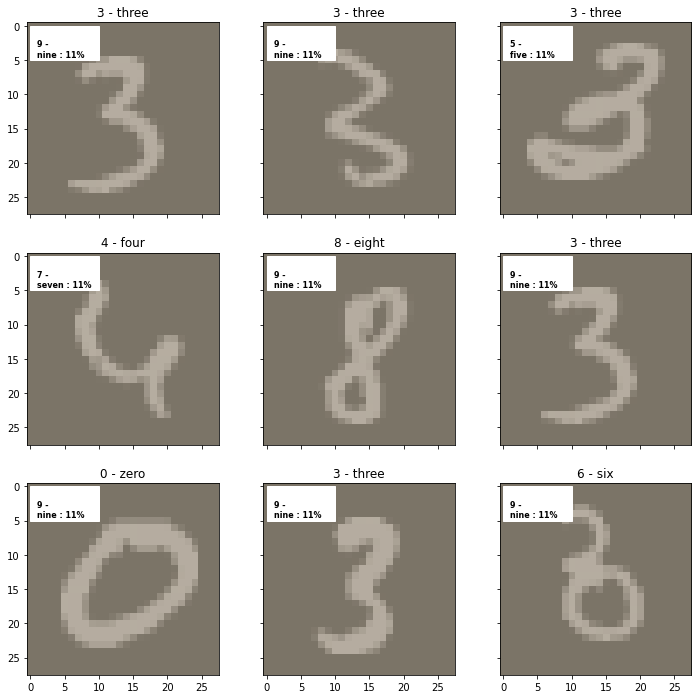

In [26]:
show_some_predictions(loaders_dict, best_result["lmodule_best"])

### Re-train the model on all available data with the same hyper-parameters

In [27]:
FT_TUNE_CONFIG = TUNE_CONFIG.copy()
FT_TUNE_CONFIG["val_loader_name"] = None
FT_TUNE_CONFIG["train_loader_name"] = "full_train_loader"
FT_TUNE_CONFIG["metric_to_optimize"] = "train_f1_epoch"

In [28]:
FT_CONFIG = CONFIG.copy()
# FT_CONFIG['max_epochs'] = 19
FT_CONFIG["max_epochs"] = best_result["best_epoch"]

In [29]:
full_train_result = ptl_ray_runner.run_single_trial(
    LMODULE_CLASS,
    FT_CONFIG,
    FT_TUNE_CONFIG,
)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores

  | Name              | Type           | Params
-----------------------------------------------------
0 | model             | Backbone       | 235 K 
1 | train_metric_calc | LitMetricsCalc | 0     
2 | val_metric_calc   | LitMetricsCalc | 0     
3 | test_metric_calc  | LitMetricsCalc | 0     
-----------------------------------------------------
0         Trainable params
235 K     Non-trainable params
235 K     Total params


|   Train |   train_f1 |   train_acc |   train_rec |   train_prec |   train_loss |
|--------:|-----------:|------------:|------------:|-------------:|-------------:|
|       0 |     0.0326 |      0.1031 |      0.1024 |       0.0238 |       2.3037 |


|   Train |   train_f1 |   train_acc |   train_rec |   train_prec |   train_loss |
|--------:|-----------:|------------:|------------:|-------------:|-------------:|
|       1 |     0.0347 |      0.1047 |      0.1001 |       0.0242 |       2.3028 |


|   Train |   train_f1 |   train_acc |   train_rec |   train_prec |   train_loss |
|--------:|-----------:|------------:|------------:|-------------:|-------------:|
|       2 |     0.0386 |      0.0969 |      0.1038 |       0.0807 |       2.3035 |


|   Test |   train_f1 |   test_f1 |   train_acc |   test_acc |   train_rec |   test_rec |   train_prec |   test_prec |   train_loss |   test_loss |
|-------:|-----------:|----------:|------------:|-----------:|------------:|-----------:|-------------:|------------:|-------------:|------------:|
|      2 |     0.0386 |    0.0304 |      0.0969 |     0.1094 |      0.1038 |     0.1015 |       0.0807 |      0.0185 |       2.3035 |      2.3031 |


In [30]:
"""
FT_REVAL_TUNE_CONFIG = FT_TUNE_CONFIG.copy()
FT_REVAL_TUNE_CONFIG['val_loader_name'] = 'full_train_loader'
"""

"\nFT_REVAL_TUNE_CONFIG = FT_TUNE_CONFIG.copy()\nFT_REVAL_TUNE_CONFIG['val_loader_name'] = 'full_train_loader'\n"

In [31]:
lmodule_best = full_train_result["lmodule_best"]
loaders_dict = configure_dataloaders(
    FT_CONFIG["batch_size"], n_workers=FT_TUNE_CONFIG["cpu_per_trial"]
)
train_repeated_result = full_train_result["trainer"].test(
    lmodule_best, test_dataloaders=loaders_dict["test_loader"], verbose=False
)

|   Test |   train_f1 |   test_f1 |   train_acc |   test_acc |   train_rec |   test_rec |   train_prec |   test_prec |   train_loss |   test_loss |
|-------:|-----------:|----------:|------------:|-----------:|------------:|-----------:|-------------:|------------:|-------------:|------------:|
|      2 |     0.0386 |    0.0304 |      0.0969 |     0.1094 |      0.1038 |     0.1015 |       0.0807 |      0.0185 |       2.3035 |      2.3031 |


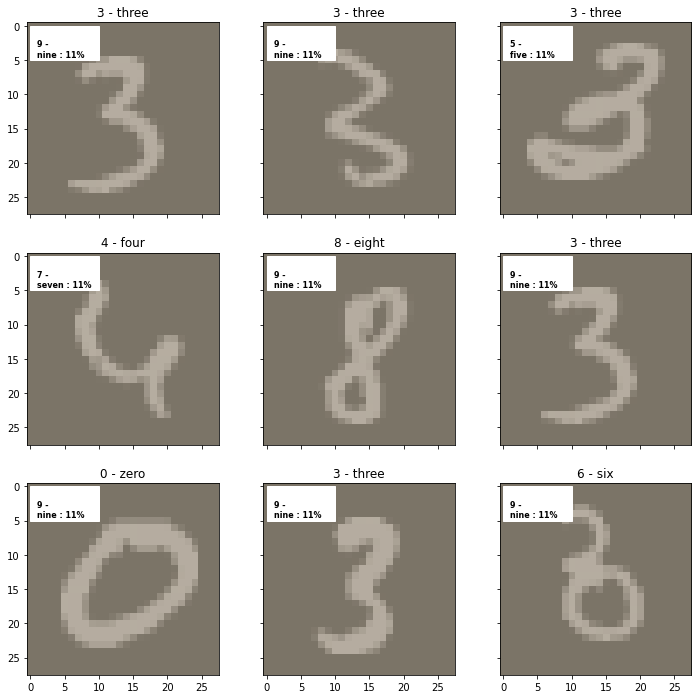

In [32]:
show_some_predictions(loaders_dict, full_train_result["lmodule_best"])